In [1]:
import pandas as pd 
import numpy as np 
from Bio import SeqIO
import src.tools.download
from src.tools import MMSeqs
from src.dataset import Dataset
from src.files import FASTAFile, GBFFFile
from src.clusterer import Clusterer
from tqdm import tqdm
import os
import json 
import seaborn as sns
from src import fillna 
import matplotlib.pyplot as plt 
from src.split import ClusterStratifiedShuffleSplit

%load_ext autoreload
%autoreload 2

# Because genomes are constantly being re-annotated, the GBFF files I downloaded a month or so ago are now not aligned with the 
# protein files I used to generate the most recent round of embeddings (05/23/2025). GBFF files were re-downloaded for 
# the Campylobacterota phylum on 05/25/2025. 

# ncbi = src.tools.download.NCBI()
# ncbi.get_genomes(genome_ids=genome_ids, include=['gbff'], dirs={'gbff':'../data/ncbi/gbffs/'})
# ncbi.cleanup()

In [4]:
# Changing my training dataset strategy. Instead going to use the sequences directly from NCBI. 
genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index.values 


In [ ]:
# Want to build the dataset for Campylobacterota, but filter out the "suspect" sequences, i.e. those which are both hypothetical
# and have only ab initio evidence (i.e. no evidence of conservation). 

is_hypothetical = lambda df : df['product'] == 'hypothetical protein'
is_ab_initio = lambda df : df.evidence_type == 'ab initio prediction'
is_suspect = lambda df : is_hypothetical(df) & is_ab_initio(df) # This will be False for intergenic sequences. 

campylobacterota_df = list()
for genome_id in tqdm(genome_ids, desc='Building Campylobacterota dataset.'):
    protein_path = f'../data/ncbi/proteins/{genome_id}_protein.faa'
    gbff_path = f'../data/ncbi/gbffs/{genome_id}_genomic.gbff'

    gbff_df = GBFFFile(gbff_path).to_df()
    gbff_df = gbff_df[(gbff_df.feature == 'CDS') & (~gbff_df.pseudo)].copy()
    copy_numbers = gbff_df.protein_id.value_counts() # There are multiple copies of the same protein at different coordinates in the GBFF files with different coordinates. 
    gbff_df['copy_number'] = gbff_df.protein_id.map(copy_numbers)
    gbff_df = gbff_df.drop_duplicates('protein_id').copy()
    gbff_df = gbff_df.drop(columns=['seq']) # Use the sequences from the protein DataFrame, just to make sure everything is equal. 
    gbff_df = gbff_df.set_index('protein_id')
    gbff_df.index.name = 'id'

    protein_df = FASTAFile(path=protein_path).to_df(prodigal_output=False)
    protein_df = protein_df.drop(columns=['description'])

    assert len(protein_df) == len(gbff_df), 'Expected the number of non-pseudo CDS entries in the GBFF file to match the entries in the FASTA file.'
    assert np.all(np.sort(protein_df.index) == np.sort(gbff_df.index)), 'Expected the number of non-pseudo CDS entries in the GBFF file to match the entries in the FASTA file.'
    assert protein_df.index.is_unique and gbff_df.index.is_unique, 'Expected the indices of both DataFrames to be unique.'

    campylobacterota_df.append(protein_df.merge(gbff_df, left_index=True, right_index=True).assign(genome_id=genome_id))

campylobacterota_df = pd.concat(campylobacterota_df)

mask = is_suspect(campylobacterota_df)
print(f'Removing {mask.sum()} suspect sequences from the Campylobacterota dataset.')
campylobacterota_df = campylobacterota_df[~mask].copy()

campylobacterota_df.to_csv('../data/campylobacterota.csv')

Building Campylobacterota dataset.: 100%|██████████| 197/197 [06:16<00:00,  1.91s/it]


Removing 44475 suspect sequences from the Campylobacterota dataset.
Removing 341 sequences exceeding the maximum length from the Campylobacterota dataset.


In [78]:
antifam_df = pd.read_csv('../data/antifam.csv', index_col=0)
campylobacterota_df = pd.read_csv('../data/campylobacterota.csv', index_col=0)

is_bacterial = lambda df : np.array(['2' in lineage.split(' ') for lineage in df.lineage])

mask = ~is_bacterial(antifam_df)
print(f'Removing {mask.sum()} non-bacterial sequences from the AntiFam dataset.')
antifam_df = antifam_df[~mask].copy()


Removing 9789 non-bacterial sequences from the AntiFam dataset.


In [205]:
campylobacterota_df['library_entry_name'] = campylobacterota_df.genome_id 
campylobacterota_df['label'] = 1

antifam_df['library_entry_name'] = 'antifam'
antifam_df['label'] = 0

dataset_df = pd.concat([antifam_df, campylobacterota_df])
dataset_df = fillna(dataset_df, rules={str:'none', bool:False, int:0, float:0})

mask = (dataset_df.seq.apply(len) >= 2000) # Upper length bound is non-inclusive. 
print(f'Removing {mask.sum()} sequences exceeding the maximum length from the Campylobacterota dataset.')
dataset_df = dataset_df[~mask].copy()

def check_duplicate_ids_have_identical_sequences(dataset_df):
    duplicate_ids = dataset_df.index[dataset_df.index.duplicated()].unique()
    for id_ in tqdm(duplicate_ids, desc='check_duplicate_ids_have_identical_sequences'):
        seqs = dataset_df.seq[dataset_df.index == id_]
        assert np.all(seqs == seqs.iloc[0]), f'check_duplicate_ids_have_identical_sequences: Sequences with ID {id_} are not equal.'

# check_duplicate_ids_have_identical_sequences(dataset_df)

mask = dataset_df.seq.duplicated(keep='first')
print(f'Removing {mask.sum()} duplicate sequences from the Campylobacterota dataset')
dataset_df = dataset_df[~mask].copy()

dataset_df.to_csv('../data/dataset.csv')


Removing 16 sequences exceeding the maximum length from the Campylobacterota dataset.
Removing 9522 duplicate sequences from the Campylobacterota dataset


In [207]:
dataset_subset_df = dataset_df.sample(5000, random_state=42)
dataset_subset_df.to_csv('../data/dataset_subset.csv')

In [ ]:
# What is a good estimate for the number of clusters? Maybe use 50 percent sequence similarity?
mmseqs = MMSeqs()
mmseqs_cluster_df = mmseqs.cluster(dataset_df, job_name='cluster', output_dir='../data', sequence_identity=0.5, overwrite=False)
mmseqs.cleanup()
print('Number of clusters:', dataset_df.cluster_label.nunique())

In [236]:
def get_cluster_info(dataset_df:pd.DataFrame) -> pd.DataFrame:

    df = list()
    for cluster_label, cluster_df in dataset_df.groupby('cluster_label'):
        cluster_dists = cluster_df.distance_to_cluster_center
        row = dict()
        row['cluster_label'] = cluster_label
        row['max_distance_to_cluster_center'] = cluster_dists.max()
        row['mean_distance_to_cluster_center'] = cluster_dists.mean()
        row['min_distance_to_cluster_center'] = cluster_dists.min()
        row['size'] = len(cluster_df)
        row['homogenous'] = (cluster_df.label.nunique() == 1)

        n_real, n_spurious = (cluster_df.label == 1).sum(), (cluster_df.label == 0).sum()
        row['n_spurious'] = n_spurious
        row['n_real'] = n_real
        # row['majority_label'] = np.nan if (n_real == n_spurious) else int(n_real > n_spurious)
        row['majority_label'] = int(n_real >= n_spurious)

        if not row['homogenous']:
            majority_label = row['majority_label']
            minority_label = int(not majority_label)
            row['mean_distance_to_cluster_center_majority_label'] = cluster_df.distance_to_cluster_center[cluster_df.label == majority_label].mean()
            row['mean_distance_to_cluster_center_minority_label'] = cluster_df.distance_to_cluster_center[cluster_df.label == minority_label].mean()        
        df.append(row)
    df = pd.DataFrame(df).set_index('cluster_label')
    return df

In [237]:
cluster_info_df = get_cluster_info(dataset_df)

In [238]:
non_homogenous_cluster_labels = cluster_info_df[~cluster_info_df.homogenous].index 

cluster_info_df[~cluster_info_df.homogenous]

,max_distance_to_cluster_center,mean_distance_to_cluster_center,min_distance_to_cluster_center,size,homogenous,n_spurious,n_real,majority_label,mean_distance_to_cluster_center_majority_label,mean_distance_to_cluster_center_minority_label
cluster_label,,,,,,,,,,
702,23.494099,20.647438,15.791010,12,False,11,1,0,20.560061,21.608585
743,23.012283,19.305932,14.816315,10,False,9,1,0,18.894115,23.012283
776,39.200905,27.412785,19.229019,11,False,10,1,0,27.433086,27.209781
843,27.783935,23.158421,20.149343,11,False,10,1,0,23.196542,22.777213
854,20.132148,19.012101,18.062193,3,False,2,1,0,19.097170,18.841962
...,...,...,...,...,...,...,...,...,...,...
44226,28.462273,24.792770,19.807258,3,False,1,2,1,24.134766,26.108779
44502,21.192584,16.981270,11.009998,9,False,1,8,1,16.454856,21.192584
44519,29.466210,12.545223,7.903213,5,False,4,1,0,8.314976,29.466210


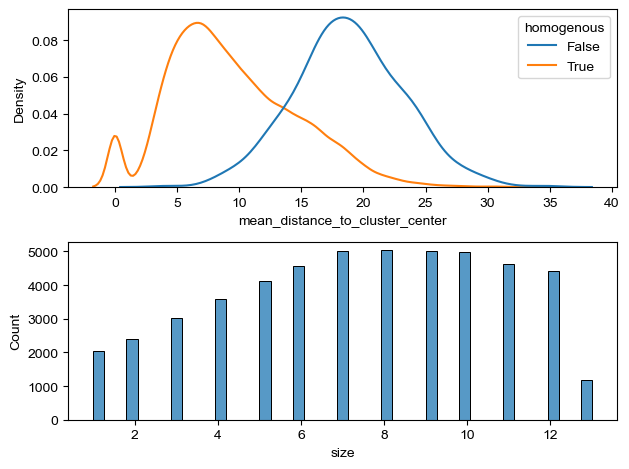

In [ ]:
# For the clusters that aren't homogenous, are there differences in how far apart the different labels are from the cluster center?
# Dictates how I should handle non-homogenous clusters. If there are clear outliers within clusters, seems straightforward to just filter them out. 

fig, (ax_a, ax_b) = plt.subplots(nrows=2)

ax_df = cluster_info_df[['homogenous', 'mean_distance_to_cluster_center', 'size']].copy()

sns.kdeplot(ax=ax_a, data=ax_df, x='mean_distance_to_cluster_center', hue='homogenous', common_norm=False)

sns.histplot(ax=ax_b, data=ax_df, x='size')

fig.tight_layout()

plt.show()

In [25]:
def train_test_split(dataset_path:str='../data/dataset_dereplicated.csv', cluster_path:str='../data/dataset_dereplicated_cluster.csv'):
    dataset = Dataset.from_csv(dataset_path, feature_type=None)
    splits = ClusterStratifiedShuffleSplit(dataset, cluster_path=cluster_path, n_splits=1)
    train_dataset, test_dataset = list(splits)[0]
    train_dataset.to_csv('../data/train_dataset.csv', metadata=True)
    test_dataset.to_csv('../data/test_dataset.csv', metadata=True)

train_test_split()

ClusterStratifiedShuffleSplit._split_non_homogenous_clusters: Found 538 non-homogenous clusters.
ClusterStratifiedShuffleSplit._load_clusters: Found 2001 singleton clusters with "real" labels.
ClusterStratifiedShuffleSplit._load_clusters: Found 422 singleton clusters with "spurious" labels.
ClusterStratifiedShuffleSplit.__init__: Adjusted training and test sizes are 0.801, 0.199.


In [26]:
train_dataset_df = pd.read_csv('../data/train_dataset.csv', index_col=0)
test_dataset_df = pd.read_csv('../data/test_dataset.csv', index_col=0)

In [30]:
train_dataset_df.cluster_label.nunique()

50538

In [33]:
test_dataset_df.columns

Index(['antifam_name', 'antifam_id', 'product', 'ncbi_taxonomy_id', 'organism',
       'seq', 'lineage', 'library_entry_name', 'label', 'feature', 'contig_id',
       'note', 'pseudo', 'locus_tag', 'inference', 'experiment',
       'ribosomal_slippage', 'strand', 'start', 'stop', 'partial',
       'continuous', 'translation_table', 'codon_start', 'evidence_type',
       'evidence_category', 'evidence_details', 'evidence_source', 'used_pgap',
       'copy_number', 'genome_id', 'cluster_label'],
      dtype='object')